# Massey Matrix

### Outline
- Weighting Calculations
- Importing Data
- Building Massey Matrix
- Solving matrix
- Ranking

In [1]:
import pandas as pd 
import scipy
import numpy as np

## Weighting Calculations
We use the logistic function to weight tournements, so early tournements have a smaller influence and more recent tournements have a larger influence. 

We also increase the weight of previous majors, and further increase previous masters.

The weighting of tournments vary as follows:
+ Normal tournement: (.1, .5)
+ Non-Masters majors: (..2 : .7)
+ Masters: (.6, 1.2)

In [2]:
MAJORS_IDS = {"2010" : [797, 798, 799],
            "2011" : [981, 982, 983],
             "2012" : [1013, 1017, 1018], 
              "2013" : [1200, 1204, 1206], 
              "2014" : [1325, 1329, 1330], 
              "2015" : [2249, 2253, 2255], 
              "2016" : [2501, 2505, 2507], 
              "2017" : [3066, 2710, 2712], 
              "2018" : [401025255, 401025259, 401025263], 
              "2019" : [401056552, 401056556, 401056547], 
              "2020" : [], 
             }
MASTERS_IDS = {"2010" : 774, 
              "2011" : 980,
             "2012" : 1005, 
              "2013" : 1192, 
              "2014" : 1317, 
              "2015" : 2241, 
              "2016" : 2493, 
              "2017" : 2700, 
              "2018" : 401025221, 
              "2019" : 401056527, 
              "2020" : 0, 
              }


These functions calculate the weight for each tournement. 

In [3]:
from scipy.special import expit
def sigmoid_x_map(num):
    '''Maps an integer x (0, 10) to (-6, 6)'''
    return -6 + ((num/10) * 12)

def year_int(year):
    return int(year[-2:]) - 10

def masters(year):
    '''-6 < year < 6'''
    return (.6 + .4 * expit(year))
def major(year):
    return (.2 + .5 * expit(year))
def non_major(year):
    return (.1 + .4 * expit(year))

def get_weight(year, tourn_id):
    num = year_int(year)
    if tourn_id == MASTERS_IDS[year]:
        x = sigmoid_x_map(num)
        return masters(x)
    elif tourn_id in MAJORS_IDS[year]:
        x = sigmoid_x_map(num)
        return major(x)
    else:
        x = sigmoid_x_map(num)
        return non_major(x)
    


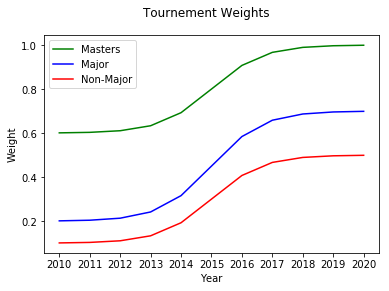

In [5]:
import matplotlib.pyplot as plt
years = ['2010', '2011', '2012', '2013', '2014', '2015',
         '2016', '2017', '2018', '2019', '2020']
x = np.array([sigmoid_x_map(year_int(x)) for x in years])
masters_weights =  masters(x)
majors_weights =  major(x)
non_majors_weights = non_major(x)
fig = plt.figure()
fig.suptitle('Tournement Weights')
plt.xlabel('Year')
plt.ylabel('Weight')
plt.plot(years, masters_weights, color='green', label='Masters')
plt.plot(years, majors_weights, color='blue', label='Major')
plt.plot(years, non_majors_weights, color='red', label='Non-Major')
plt.legend()
plt.savefig("weights.jpg", quality=95, format="jpg")
plt.show()

## Import previously scraped data

Within the data folder, there is a subfolder for each year. Each year folder contains csv files with player data for each tournement. The name of the folder is the tournemnet ID from ESPN (found in the URL).

Open every file in each year folder and save them as a Pandas dataframe. 
Put each dataframe in a dictionary with its specific weight based on the year and type of tournement.


In [6]:
import os
dfs = {}
weights = []
for year in os.listdir('data'):
    if year[0] == '2':
        # if the file is a year (there are some other files in the folder)
        dfs[year] = []
        for file in os.listdir('data/' + year):
            # Note: file = tournementID
            weight = get_weight(year, file)
            df = pd.read_csv('data/' + year + '/' +file).set_index("PLAYER")
            old_len = len(df)
            df = df.drop_duplicates()
            if len(df) != old_len:
                pass
            dfs[year].append((df, weight))


Example Dataframe of one tournement. We will only be using the columns of each round (R1 - R4). Notice that not all players play all rounds. Some withdraw or are cut. 

In [7]:
df.head(2)

,POS,TO PAR,R1,R2,R3,R4,TOT,EARNINGS,FEDEX PTS
PLAYER,,,,,,,,,
Branden Grace,1,-9,66.0,74.0,69.0,66.0,275,"$1,062,000",500
Russell Knox,T2,-7,72.0,65.0,73.0,67.0,277,"$519,200",245


In [8]:
df.tail(5)

,POS,TO PAR,R1,R2,R3,R4,TOT,EARNINGS,FEDEX PTS
PLAYER,,,,,,,,,
J.J. Henry,-,CUT,74.0,80.0,NaN,NaN,154,--,0
Tommy Gainey,-,WD,69.0,NaN,NaN,NaN,69,--,0
Harris English,-,WD,77.0,NaN,NaN,NaN,77,--,0
Mike Weir,-,WD,78.0,NaN,NaN,NaN,78,--,0
Erik Compton,-,WD,81.0,NaN,NaN,NaN,81,--,0


Next, we remove all of the amateurs and people who withdrew or were disqualified from the dataset.

When a player withdraws, they get a score of whatever they had when they withdrew—42 through 9 holes, for example— so it looks like the got a 42 on the round and beat everybody.

People who were cut after two days are still in the dataset. They are considered to play a "game" against every other player on the first two days, but not on the last two. Including rounds not played as losses would extrapolate poor performance on the first two days to the last two days, which would introduce bias. 

In [9]:
clean_data = {}
for year in dfs: 
    clean_data[year] = []
    for df, weight in dfs[year]:
        split_names = [] 
        for player in df.index: 
            split_names.append(player.split(' '))
        df['name_arr'] = split_names 
        df['pro'] = df['name_arr'].apply(lambda arr : arr[-1] != '(a)')
        df = df[df.pro]
        df['finished'] = df['TO PAR'].apply(lambda s : s != "WD" and s != "DQ")
        df = df[df.finished]
        clean_data[year].append((df, weight))

/Users/chrisamoroso/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


## Building Massey Matrix

To validate our results, we are test the algorithm with one tournement. For simplicity, we used the first one in the dataset. The matrix is saved in a dataframe named Massey_A.

In [10]:
def add_dicts(s1, s2):
    '''Function that adds the values of two dictionaries by key'''
    result = {}
    for name in s1:
        if name in s2: 
            result[name] = s1[name] + s2[name]
        else: 
            result[name] = s1[name]
            
    for name in s2: 
        if name not in s1:
            result[name] = s2[name]
    return result


In [14]:
player_dict = {}
massey_dict = {}
for year in clean_data:
    for df, weight in clean_data[year]:
        all_rounds = df[['R1', 'R2', 'R3', 'R4']].values.T
        rows = []
        for i, name in enumerate(df.index): 
            player_rounds = df.loc[name, ['R1', 'R2', 'R3', 'R4']].values
            if len(player_rounds) == 2:
                print(player_rounds)
                print(name)
                print(df)
                break
            try:
                player_rounds = player_rounds.reshape(4, 1)
            except: 
                player_rounds = player_rounds[0].reshape(4, 1)
            #difference between scores per round
            # positive implies a win, negative is a loss
            win_diff = all_rounds - player_rounds                

            # Number of "games" against each 
            # player in the tournement
            total_matches_arr = pd.notnull(win_diff).sum(axis=0) 
            # Number of games against yourself is 0
            total_matches_arr[i] = 0
            total_matches = total_matches_arr.sum()

            #massey method 
            # weighted number of matches against each person
            weighted_total_matches = total_matches_arr*weight
            where_are_NaNs = pd.isnull(win_diff)
            win_diff[where_are_NaNs] = 0
            # Total win differential
            massey_sum = win_diff.sum()
            # APPLY WEIGHTING
            weighted_massey_sum = massey_sum * weight
            if name in massey_dict: 
                massey_dict[name] += weighted_massey_sum
#                     massey_dict[name] += massey_sum
            else:
                massey_dict[name] = weighted_massey_sum

            # Apply weighting to the number of matches agains other players
            player_series = dict(zip(df.index, total_matches_arr*weight))

            if name in player_dict:
                player_dict[name] = add_dicts(player_series, player_dict[name])
            else:
                player_dict[name] = player_series
                


In [15]:
massey_A = pd.DataFrame(player_dict)
massey_A = massey_A.reindex(massey_A.columns).fillna(0)*-1

### Set the diagonal, bottom row, and right hand vector

In [16]:
massey = pd.Series(massey_dict)
rhv  = []
for name in massey_A.index:
#     append to right hand vector
    score = massey.loc[name] 
    rhv.append(score)
#     set the diagonal
    player_sum = massey_A.loc[:,name].sum()
    massey_A.loc[name, name] =-1* player_sum
rhv = np.array(rhv)

Save the matrix and the vector for future analysis

In [17]:
massey_A.to_csv('massey.csv')
massey.to_csv('rhv.csv', header=False)

Set the bottom row of the matrix to all 1s and the last value in the vector to 0.

In [18]:
massey_A.iloc[-1] = [1]*len(massey_A.columns)
rhv[-1] = 0

## Solve the system

We use least squares solution from scipy to solve the system. 

In [19]:
x = scipy.linalg.lstsq(massey_A.values, rhv)
ratings = pd.DataFrame({'player' : massey_A.index, 'rating' : x[0]}).set_index('player')
ratings = ratings.sort_values('rating', ascending=False)

## Ranking
Currently the ranking includes all golfers that played in a PGA tournement since 2010, so we need to reduce it to only the players in the 2020 Masters.

In [20]:
ratings.head(10)

,rating
player,
Rory McIlroy,4.528093
Jon Rahm,4.432874
Dustin Johnson,4.417170
Armando Favela,4.298809
Justin Rose,4.220091
Ignacio Garrido,4.194928
Robert MacIntyre,4.159393
Jason Day,4.122193
Hideki Matsuyama,4.095035


In [21]:
ratings.to_csv('ratings.csv')

#### Read in the 2020 Masters Roster

In [22]:
roster = pd.read_csv('2020_players.csv', header=None)
roster.head()
roster = roster[1].values

In [23]:
masters_ranks = ratings.loc[roster].sort_values('rating', ascending=False)

/Users/chrisamoroso/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [24]:
masters_ranks.head()

,rating
player,
Rory McIlroy,4.528093
Jon Rahm,4.432874
Dustin Johnson,4.417170
Justin Rose,4.220091
Jason Day,4.122193


In [25]:
masters_ranks.to_csv('masters_rankings.csv')